In [1]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset

/root/anaconda/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def frame_extract(path):
    vidObj = cv2.VideoCapture(path) 
    success = 1
    while success:
        success, image = vidObj.read()
        if success:
            yield image

In [3]:
import pandas as pd
train_label = pd.read_csv('./DAiSEE/Labels/TrainLabels.csv')
valid_label = pd.read_csv('./DAiSEE/Labels/ValidationLabels.csv')
test_label = pd.read_csv('./DAiSEE/Labels/TestLabels.csv')

In [4]:
class video_dataset(Dataset):
    def __init__(self,frame_dir,train_csv,sequence_length = 60,transform = None):
        self.folder = os.listdir(frame_dir)
        self.id = train_csv['ClipID']
        self.engagement = train_csv['Engagement']
        self.frame_dir = frame_dir
        self.transform = transform
        self.sequence_length = sequence_length
        l = 300%sequence_length
        self.length = 300-l
        self.skip_length = int(self.length/self.sequence_length)
    def __len__(self):
        return len(self.id)
    def __getitem__(self,idx):
        id_1 = self.id[idx][:6]
        path1 = os.path.join(self.frame_dir,id_1)
        id_2 = self.id[idx][:-4]
        path2 = os.path.join(path1,id_2)
        seq_image = list()
        i = np.random.randint(0,self.skip_length)
        video_path = os.path.join(path2,os.listdir(path2)[0])
        image_list = []
        for image in frame_extract(video_path):
            image_list.append(image)
        image = image_list[i]
        face_locations = face_recognition.face_locations(image)
        flag = 0
        if(len(face_locations) == 0):
            flag = 1
        else:
            top,right,bottom,left = face_locations[0]
            shift_r = min(50,image.shape[1]-right)
            shift_l = min(50,left)
            shift_top = min(50,top)
            shift_bottom = min(30,image.shape[0]-bottom)
        
        while i<self.length:
            image = image_list[i]
            if(flag==1):
                face_locations = face_recognition.face_locations(image)
                if(len(face_locations)>0):
                    top,right,bottom,left = face_locations[0]
                    flag = 0
                    shift_r = min(30,image.shape[1]-right)
                    shift_l = min(30,left)
                    shift_top = min(30,top)
                    shift_bottom = min(30,image.shape[0]-bottom)
                    
                    image = image[top-shift_top:bottom+shift_bottom,left-shift_l:right+shift_r,:]
                    if(self.transform):
                        image = self.transform(image)
                    seq_image.append(image)
                    i = i+self.skip_length
                    continue
                if(self.transform):
                    image = self.transform(image)
                seq_image.append(image)
                i = i+self.skip_length
                continue
            image = image[top-shift_top:bottom+shift_bottom,left-shift_l:right+shift_r,:]
            if(self.transform):
                image = self.transform(image)
            seq_image.append(image)
            i = i+self.skip_length
        seq_image = torch.stack(seq_image)
        label = self.engagement[idx]
        seq_image = seq_image.permute((1,0,2,3))
        return seq_image,label

In [5]:
from torchvision import transforms
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
from tqdm.autonotebook import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys
im_size = 128
mean = [0.5,0.5,0.5]
std = [0.5,0.5,0.5]
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset('./DAiSEE/DataSet/Train',train_label,sequence_length = 60,transform = train_transforms)
val_data = video_dataset('./DAiSEE/DataSet/Validation',valid_label,sequence_length = 60,transform = test_transforms)

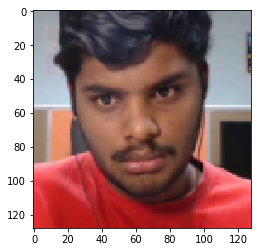

In [6]:
import cv2
import face_recognition
image,_ = train_data[4000]
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.5,0.5,0.5] + [0.5,0.5,0.5]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()
im_plot(image[:,20,:,:])

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from functools import partial
from torchvision import models
__all__ = ['resnet50', 'resnet101', 'resnet152', 'resnet200']


def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()
    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, head_conv=1):
        super(Bottleneck, self).__init__()
        if head_conv == 1:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm3d(planes)
        elif head_conv == 3:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), bias=False, padding=(1, 0, 0))
            self.bn1 = nn.BatchNorm3d(planes)
        else:
            raise ValueError("Unsupported head_conv!")
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=(1, 3, 3), stride=(1, stride, stride), padding=(0, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ELU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters


class SlowFast(nn.Module):
    def __init__(self, block=Bottleneck, layers=[[2,2,2,2],[3, 4, 6, 3]], class_num=27, shortcut_type='B', dropout=0.5,
                 alpha=8, beta=0.125):
        super(SlowFast, self).__init__()
        self.alpha = alpha
        self.beta = beta

        self.fast_inplanes = int(64 * beta)
        fast_inplanes = self.fast_inplanes
        self.fast_conv1 = nn.Conv3d(3, fast_inplanes, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3),
                                    bias=False)
        self.fast_bn1 = nn.BatchNorm3d(8)
        self.fast_relu = nn.ELU(inplace=True)
        self.fast_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.fast_res1 = self._make_layer_fast(block, 8, layers[1][0], shortcut_type, head_conv=3)
        self.fast_res2 = self._make_layer_fast(
            block, 16, layers[1][1], shortcut_type, stride=2, head_conv=3)
        self.fast_res3 = self._make_layer_fast(
            block, 32, layers[1][2], shortcut_type, stride=2, head_conv=3)
        self.fast_res4 = self._make_layer_fast(
            block, 64, layers[1][3], shortcut_type, stride=2, head_conv=3)

        self.slow_inplanes = 64
        slow_inplanes = self.slow_inplanes
        self.slow_conv1 = nn.Conv3d(3, slow_inplanes, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3),
                                    bias=False)
        self.slow_bn1 = nn.BatchNorm3d(64)
        self.slow_relu = nn.ELU(inplace=True)
        self.elu = nn.ELU(inplace=True)
        
        self.slow_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.slow_res1 = self._make_layer_slow(block, 64, layers[0][0], 1,shortcut_type, head_conv=1)
        self.slow_res2 = self._make_layer_slow(
            block, 128, layers[0][1], 2,shortcut_type, stride=2, head_conv=1)
        self.slow_res3 = self._make_layer_slow(
            block, 256, layers[0][2], 3,shortcut_type, stride=2, head_conv=1)
        self.slow_res4 = self._make_layer_slow(
            block, 512, layers[0][3], 4,shortcut_type, stride=2, head_conv=1)
        self.Tconv1 = nn.Conv3d(8, 16, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv2 = nn.Conv3d(32, 64, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv3 = nn.Conv3d(64, 128, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv4 = nn.Conv3d(128, 256, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.dp = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(1024)
        self.l1 = nn.Linear(1024, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.l2 = nn.Linear(256, 4)
        self.dp1 = nn.Dropout(0.5)
        model = models.video.mc3_18(pretrained=True).to('cuda')
        model.fc = Identity()
        self.model = model
    def forward(self, input):
        fast= self.FastPath(input[:, :, ::1, :, :])
        slow = self.model(input[:, :, ::2, :, :])
        x = torch.cat([slow, fast], dim=1)
        x = self.bn1(x)
        x = self.dp1(self.elu(self.l1(x)))
        x = self.dp1(self.l2(self.bn2(x)))
        return x

    def SlowPath(self, input):
        x = self.slow_conv1(input)
        x = self.slow_bn1(x)
        x = self.slow_relu(x)
        x = self.slow_maxpool(x)
        x = self.slow_res1(x)
        x = self.slow_res2(x)
        x = self.slow_res3(x)
        x = self.slow_res4(x)
        avg_pool = nn.AdaptiveAvgPool3d(1)(x)
        max_pool = nn.AdaptiveMaxPool3d(1)(x)
        x = torch.cat((avg_pool,max_pool),1)
        x = x.view(-1, x.size(1))
        return x

    def FastPath(self, input):
        x = self.fast_conv1(input)
        x = self.fast_bn1(x)
        x = self.fast_relu(x)
        x = self.fast_maxpool(x)
        x = self.fast_res1(x)
        x = self.fast_res2(x)
        x = self.fast_res3(x)
        x = self.fast_res4(x)
        avg_pool = nn.AdaptiveAvgPool3d(1)(x)
        max_pool = nn.AdaptiveMaxPool3d(1)(x)
        x = torch.cat((avg_pool,max_pool),1)
        x = x.view(-1, x.size(1))
        return x

    def _make_layer_fast(self, block, planes, blocks, shortcut_type, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.fast_inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.fast_inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=(1, stride, stride),
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.fast_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.fast_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.fast_inplanes, planes, head_conv=head_conv))
        
        return nn.Sequential(*layers)

    def _make_layer_slow(self, block, planes, blocks, ind,shortcut_type, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.slow_inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                if(ind):
                    downsample = nn.Sequential(
                      nn.Conv3d(
                          self.slow_inplanes,
                          planes * block.expansion,
                          kernel_size=1,
                          stride=(1, stride, stride),
                          bias=False), nn.BatchNorm3d(planes * block.expansion))

                else:
                  downsample = nn.Sequential(
                      nn.Conv3d(
                          self.slow_inplanes + self.slow_inplanes // self.alpha * 2,
                          planes * block.expansion,
                          kernel_size=1,
                          stride=(1, stride, stride),
                          bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        if(ind):
          layers.append(block(self.slow_inplanes, planes, stride, downsample,head_conv=head_conv))
  
        else:
          layers.append(block(self.slow_inplanes + self.slow_inplanes // self.alpha * 2, planes, stride, downsample,head_conv=head_conv))
        
        self.slow_inplanes = planes * block.expansion
        for i in range(1, blocks):
           #print(self.slow_inplanes,planes)
            layers.append(block(self.slow_inplanes, planes, head_conv=head_conv))

        return nn.Sequential(*layers)
def resnet18(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = SlowFast(Bottleneck, [[2,2,2,2],[2,2,2,2]], **kwargs)
    return model

def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = SlowFast(Bottleneck, [[2,2,2,2],[3, 4, 6, 3]], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [[3, 4, 23, 3],[3, 4, 23, 3]], **kwargs)
    return model

def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model


In [8]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [9]:
model = resnet50(class_num = 4).to('cuda')
#model.load_state_dict(torch.load('./weights_att1/slow_fast101-b0.h5')['dict'])
#model = nn.DataParallel(model)

In [11]:
#!pip install torchsummary
from torchsummary import summary
summary(model,(3,60,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 60, 64, 64]           5,880
       BatchNorm3d-2        [-1, 8, 60, 64, 64]              16
               ELU-3        [-1, 8, 60, 64, 64]               0
         MaxPool3d-4        [-1, 8, 60, 32, 32]               0
            Conv3d-5        [-1, 8, 60, 32, 32]             192
       BatchNorm3d-6        [-1, 8, 60, 32, 32]              16
               ELU-7        [-1, 8, 60, 32, 32]               0
            Conv3d-8        [-1, 8, 60, 32, 32]             576
       BatchNorm3d-9        [-1, 8, 60, 32, 32]              16
              ELU-10        [-1, 8, 60, 32, 32]               0
           Conv3d-11       [-1, 32, 60, 32, 32]             256
      BatchNorm3d-12       [-1, 32, 60, 32, 32]              64
           Conv3d-13       [-1, 32, 60, 32, 32]             256
      BatchNorm3d-14       [-1, 32, 60,

In [12]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [13]:
!git clone https://github.com/LiyuanLucasLiu/RAdam
!git clone https://github.com/nachiket273/One_Cycle_Policy
from RAdam.radam import RAdam

fatal: destination path 'RAdam' already exists and is not an empty directory.
fatal: destination path 'One_Cycle_Policy' already exists and is not an empty directory.


In [14]:
from One_Cycle_Policy.OneCycle import OneCycle

In [11]:
def lr_finder(model,train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = RAdam(model.parameters(), lr=1e-6,weight_decay = 1e-3)
    lr_finder = LRFinder(model, optimizer_ft, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=1, num_iter=1000)
    lr_finder.reset()
    lr_finder.plot()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


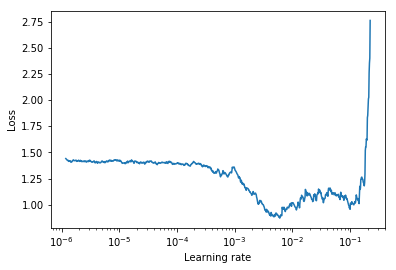

In [16]:
lr_finder(model,train_loader)

In [15]:
os.makedirs('./weights_att1',exist_ok = True)
import sys
import cv2
from torch.autograd import Variable
device = 'cuda'
criterion = nn.CrossEntropyLoss().to(device)
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

def train(model,dataloaders,device,num_epochs,lr,batch_size,patience):
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc_all = list()
    train_loader = dataloaders['train']
    iteration = 0
    iteration1 = 0
    onecyc = OneCycle(len(train_loader)*num_epochs,lr)
    optimizer = RAdam(model.parameters(), lr=lr,weight_decay = 1e-3)
    for epoch in range(num_epochs):
        print('------------------Epoch: {} ------------------'.format(epoch))
        if(epoch%20==0 and epoch!=0):
            lr = 0.9*lr
            num_epochs = num_epochs-20
            onecyc = OneCycle(len(train_loader)*num_epochs,lr)
            optimizer = RAdam(model.parameters(), lr=lr,weight_decay = 1e-3)
        
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            print('')
            print('-------------------{}------------------'.format(phase))
            if(phase  == 'train'):
                model = model.train()
            else:
                model = model.eval()
            
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.FloatTensor).to(device)
                target = target.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                output = model(data)
                del data
                loss = criterion(output, target)
                acc = 100 * (output.detach().argmax(1) == target).cpu().numpy().mean()
                del output,target
                
                epoch_metrics["loss"].append(loss.item())
                epoch_metrics["acc"].append(acc)
                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                % (
                    epoch,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                    )
                )

                if(phase =='train'):
                    loss.backward()
                    optimizer.step()
                    lr,_ = onecyc.calc()
                    update_lr(optimizer, lr)
                    iteration = iteration+1
                    writer.add_scalar('data/acc',np.mean(epoch_metrics["acc"]) , iteration)
                    writer.add_scalar('data/loss',np.mean(epoch_metrics["loss"]) , iteration)
                if(phase=='val'):
                    iteration1 = iteration1+1
                    writer.add_scalar('data/valacc',np.mean(epoch_metrics["acc"]) , iteration1)
                    writer.add_scalar('data/valloss',np.mean(epoch_metrics["loss"]) , iteration1)
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
            epoch_acc = np.mean(epoch_metrics["acc"])
            epoch_loss = np.mean(epoch_metrics["loss"])
            if(phase == 'train'):
                losses.append(epoch_loss)
                acc_all.append(epoch_acc)
                writer.add_scalar('data/accep',np.mean(epoch_metrics["acc"]) , epoch)
                writer.add_scalar('data/lossep',np.mean(epoch_metrics["loss"]) , epoch)
                save = {
                    'model':'101-b0',
                    'epoch':epoch,
                    'train_loss':epoch_loss,
                    'train_acc':epoch_acc,
                    'dict':model.state_dict(),
                    'lr':lr
                }
                torch.save(save,'./weights_att1/slow_fast101-b0-1.h5')
            print('')
            print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
    return losses,acc_all

In [ ]:
#!pip install tensorboardX
from tensorboardX import SummaryWriter
import face_recognition
writer = SummaryWriter()
train_loader = DataLoader(train_data,batch_size = 8,num_workers = 8 ,shuffle = True)
valid_loader = DataLoader(val_data,batch_size = 8,num_workers =8 ,shuffle = True)
dataloaders = {'train':train_loader , 'val':valid_loader}
loss,acc = train(model,dataloaders,'cuda',50,0.005,32,None)

------------------Epoch: 0 ------------------

-------------------train------------------
[Epoch 0/50] [Batch 669/670] [Loss: 1.089163 (1.423349), Acc: 50.00% (29.81%)]
train Accuracy: 29.813432835820894

-------------------val------------------
[Epoch 0/50] [Batch 178/179] [Loss: 1.181115 (1.367535), Acc: 40.00% (32.73%)]
val Accuracy: 32.73262661955241
------------------Epoch: 1 ------------------

-------------------train------------------
[Epoch 1/50] [Batch 669/670] [Loss: 0.892342 (1.184172), Acc: 50.00% (39.89%)]
train Accuracy: 39.88805970149254

-------------------val------------------
[Epoch 1/50] [Batch 178/179] [Loss: 1.206052 (1.168362), Acc: 40.00% (38.15%)]
val Accuracy: 38.150765606595996
------------------Epoch: 2 ------------------

-------------------train------------------
[Epoch 2/50] [Batch 669/670] [Loss: 1.142346 (1.132152), Acc: 16.67% (40.27%)]
train Accuracy: 40.26741293532338

-------------------val------------------
[Epoch 2/50] [Batch 178/179] [Loss: 0.748